In [245]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from environment import Environment
from actor import DenseActor, RandomActor
from critic import Critic
from copy import deepcopy
from tqdm import tqdm
from utils import make_simulation_plot, make_simulation_plot_2, run_environment_simulation, calculate_full_distance
import or_tools

In [246]:
n_samples_train = 3000
n_samples_test = 10
n_locations = 5
n_steps = n_locations * 2 + 1
max_demand = 10
max_capacity = 50
n_epochs = 200
approximation_level = 100

dense_actor = DenseActor(n_locations)
random_actor = RandomActor(n_locations)
critic = Critic()
optimizer = tf.keras.optimizers.legacy.Adam()

env_org = Environment(n_samples_train, n_locations, max_demand, max_capacity)
env_test = Environment(n_samples_test, n_locations, max_demand, max_capacity)

In [247]:
grads_lst = []
losses_train = []
losses_test = []
losses_test_random = []

critic_losses_train = []

all_actions_real_train = []
all_actions_real_test = []
all_actions_real_random = []

all_actions_approximation_train = []
all_actions_approximation_test = []
all_actions_approximation_random = []

In [248]:
for _ in tqdm(range(n_epochs)):
    env_train_process = deepcopy(env_org)
    env_test_process = deepcopy(env_test)
    env_test_process_random = deepcopy(env_test)
    with tf.GradientTape(persistent=True) as tape:
        actions_approximation_train, actions_real_train = run_environment_simulation(
            env_train_process, dense_actor, n_steps, approximation_level
        )
        actions_approximation_test, actions_real_test = run_environment_simulation(
            env_test_process, dense_actor, n_steps, approximation_level
        )

        actions_approximation_test_random, actions_real_test_random = run_environment_simulation(
            env_test_process_random, random_actor, n_steps, approximation_level
        )

        actions_for_critic_train = tf.reshape(actions_approximation_train, (-1, n_samples_train))
        actions_for_critic_train = tf.transpose(actions_for_critic_train)
        critic_estimation_train = critic(env_train_process, tf.convert_to_tensor(actions_for_critic_train))

        full_distance_train = calculate_full_distance(tf.convert_to_tensor(actions_approximation_train))
        loss_train = tf.reduce_mean(full_distance_train)

        full_distance_test = calculate_full_distance(tf.convert_to_tensor(actions_approximation_test))
        loss_test = tf.reduce_mean(full_distance_test)

        full_distance_test_random = calculate_full_distance(tf.convert_to_tensor(actions_approximation_test_random))
        loss_test_random = tf.reduce_mean(full_distance_test_random)

        losses_train.append(loss_train)
        losses_test.append(loss_test)
        losses_test_random.append(loss_test_random)

        advantage_train = full_distance_train - critic_estimation_train
        loss_train_advantage = loss_train * advantage_train * 0.001
        loss_train_critic = advantage_train ** 2
        critic_losses_train.append(loss_train_critic)

    all_actions_approximation_train.append(actions_approximation_train)
    all_actions_approximation_test.append(actions_approximation_test)

    all_actions_real_train.append(actions_real_train)
    all_actions_real_test.append(actions_real_test)

    grads = tape.gradient(loss_train_advantage, dense_actor.trainable_variables)
    grads_and_vars = zip(grads, dense_actor.trainable_variables)
    optimizer.apply_gradients(grads_and_vars)
    grads_lst.append(grads)

    critic_grads = tape.gradient(loss_train_critic, critic.trainable_variables)
    critic_grads_and_vars = zip(critic_grads, critic.trainable_variables)
    optimizer.apply_gradients(critic_grads_and_vars)

100%|██████████| 200/200 [14:01<00:00,  4.21s/it]


In [249]:
tf_all_actions_approximation_train = tf.convert_to_tensor(all_actions_approximation_train)
tf_all_actions_approximation_test = tf.convert_to_tensor(all_actions_approximation_test)

tf_all_actions_real_train = tf.convert_to_tensor(all_actions_real_train)
tf_all_actions_real_test = tf.convert_to_tensor(all_actions_real_test)
# shape: [n_epochs x n_steps x n_samples x 2]

In [250]:
def fun(ls, n):
    return [np.mean(ls[i : i + n]) for i in range(0, len(ls) - n)]

# LOSSES

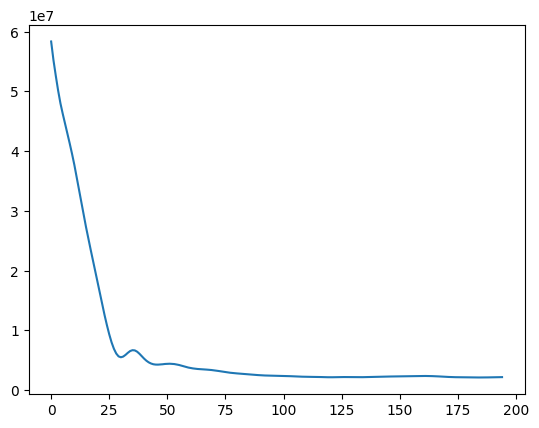

In [251]:
plt.plot(fun(critic_losses_train, 5))
plt.show()

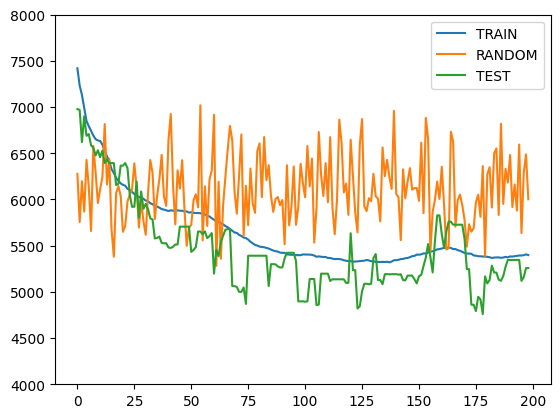

In [252]:
smoothing = 1
plt.plot(fun(losses_train, smoothing), label="TRAIN")
plt.plot(fun(losses_test_random, smoothing), label="RANDOM")
plt.plot(fun(losses_test, smoothing), label="TEST")
plt.legend()
plt.ylim([4000, 8000])
plt.show()

# SAMPLES

In [253]:
results_or_tools = []
routes_or_tools = []

for i in range(n_samples_test):
    data_or_tools = or_tools.create_data_model(env_test, i)
    td, _, r = or_tools.or_tools_solve(data_or_tools)

    results_or_tools.append(td)
    routes_or_tools.append(r)

In [254]:
distances_0_epoch = calculate_full_distance(tf.convert_to_tensor(tf_all_actions_approximation_test)[0, :,])
distances_last_epoch = calculate_full_distance(tf.convert_to_tensor(tf_all_actions_approximation_test)[-1, :,])

In [255]:
assert len(results_or_tools) == n_samples_test
assert distances_0_epoch.shape == n_samples_test
assert distances_last_epoch.shape == n_samples_test

In [256]:
print("OR TOOLS: ", f"{np.mean(results_or_tools)}")
print("0 EPOCH: ", f"{np.mean(distances_0_epoch)}")
print("LAST EPOCH: ", f"{np.mean(distances_last_epoch)}")

OR TOOLS:  3956.2
0 EPOCH:  6978.3701171875
LAST EPOCH:  5441.6181640625


In [257]:
sample_id = 2

In [258]:
def calculate_full_distance2(actions):
    actions_shifted = tf.concat((tf.expand_dims(actions[-1], 0), actions[:-1]), 0)

    distances = tf.math.sqrt(tf.reduce_sum(tf.math.square(actions_shifted - actions), -1) + 0.1**8)
    return distances
    full_distance = tf.reduce_sum(distances, axis=0)

    return full_distance

3410


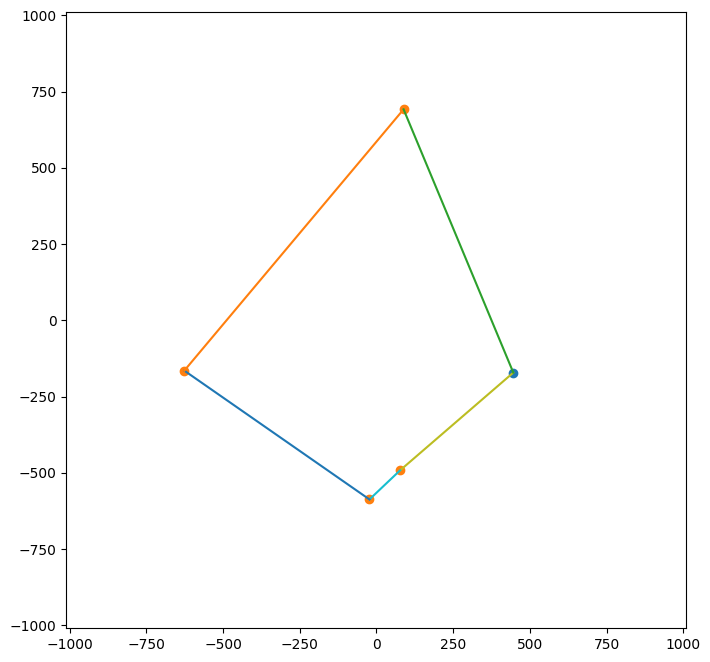

In [259]:
# OR TOOLS
print(results_or_tools[sample_id])
flat_list = [x for xs in routes_or_tools[sample_id] for x in xs]
make_simulation_plot_2(env_test_process.locations[sample_id], flat_list)

6243.515


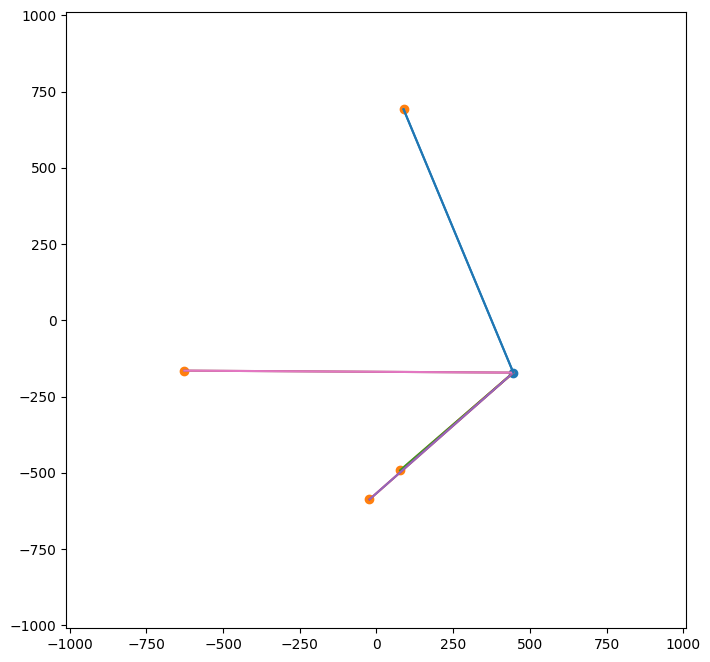

In [260]:
# TEST SET - 0 EPOCH
l1 = calculate_full_distance(tf.convert_to_tensor(tf_all_actions_approximation_test)[0, :, sample_id])
print(l1.numpy())
make_simulation_plot(env_test_process.locations[sample_id], tf_all_actions_real_test[0, :, sample_id])

4256.6313


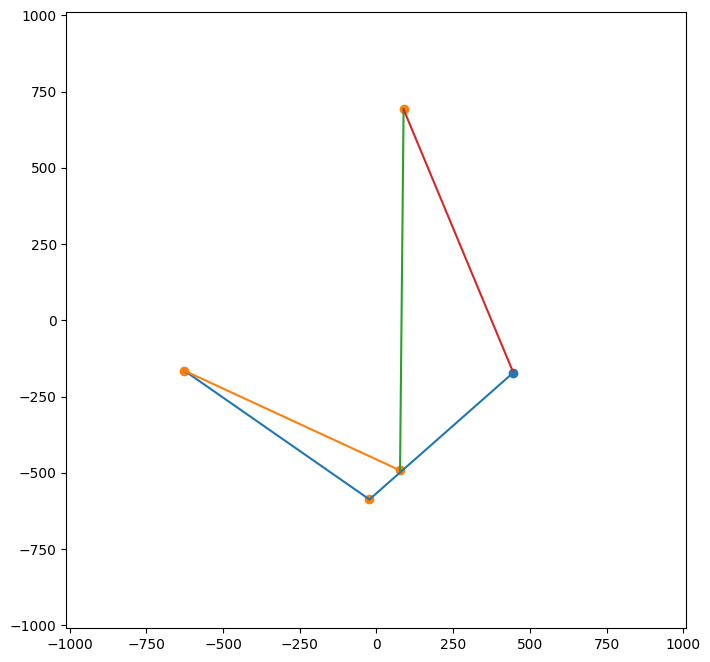

In [261]:
# TEST SET - LAST EPOCH
l1 = calculate_full_distance(tf.convert_to_tensor(tf_all_actions_approximation_test)[-1, :, sample_id])
print(l1.numpy())
make_simulation_plot(env_test_process.locations[sample_id], tf_all_actions_real_test[-1, :, sample_id])